<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EFp2_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# TRAINING SET
train1 = scipy.io.loadmat('/content/train1.mat')
train2 = scipy.io.loadmat('/content/train2.mat')

Xtr1 = train1['Xtr']
Str1 = train1['Str']
Xtr2 = train2['Xtr']
Str2 = train2['Str']

Xtr = np.append(Xtr1, Xtr2, axis=0)
Str = np.append(Str1, Str2, axis=0)

# VALIDATION SET
valid = scipy.io.loadmat('/content/valid.mat')

Xv = valid['Xv']
Sv = valid['Sv']

# TEST SET
test = scipy.io.loadmat('/content/test.mat')

Xtest = test['Xt']
Stest = test['St']

print('Training Set:')
print('Xtr shape: ', Xtr.shape)
print('Str shape: ', Str.shape)

print('Validation Set:')
print('Xv shape:', Xv.shape)
print('Sv shape:', Sv.shape)

print('Test Set:')
print('Xt shape:', Xtest.shape)
print('St shape:', Stest.shape)

Training Set:
Xtr shape:  (40000, 3072)
Str shape:  (40000, 10)
Validation Set:
Xv shape: (10000, 3072)
Sv shape: (10000, 10)
Test Set:
Xt shape: (10000, 3072)
St shape: (10000, 10)


In [2]:
# np.random.seed(261663) # Using my RA as seed

## ELM

### V matrix

In [3]:
INPUT_LENGHT = Xtr.shape[1] # 784
HIDDEN_UNITS = 1500

Vin = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS],loc=0.0, scale=0.01)
print('Input Weight shape: {shape}'.format(shape=Vin.shape))


Input Weight shape: (3072, 1500)


In [4]:
ones = np.ones((INPUT_LENGHT, 1))

Vin = np.append(ones, Vin, axis = 1)

Vin.shape

(3072, 1501)

### Compute H Matrix

In [5]:
def input_to_hidden(x):
    a = np.matmul(x, Vin)
    a = np.maximum(a, 0, a) # ReLU
    return a

### Crude search for the regularization coefficient:

In [6]:
N, m = Xtr.shape 
Nv, mv = Xv.shape

v_c = []
v_hit_rate_tr = []
v_hit_rate_v = []
hit_rate_max = 0


print('Crude search for the regularization coefficient:')

for p in np.arange(-4, 20, 2, dtype=float):
  C = 2**(p)
  v_c.append(C) # Vector containing every value of crude search

  X = input_to_hidden(Xtr)
  Xt = np.transpose(X)

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.linalg.inv(np.dot(Xt, X) + C * np.identity(X.shape[1])), np.dot(Xt, Str))

  # Training set:
  S_est_tr = np.dot(X, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if Str[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr.append(hit_rate_tr)


  X = input_to_hidden(Xv)
  # Validation set:
  S_est_v = np.dot(X, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max:
    hit_rate_max = hit_rate_v
    c_min = C
    w_min = w


Crude search for the regularization coefficient:


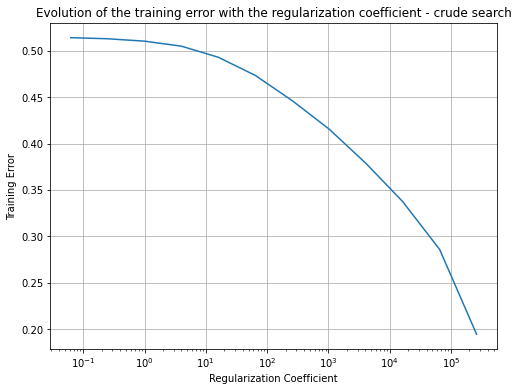

In [7]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Training Error')
plt.semilogx(v_c, v_hit_rate_tr)
plt.title('Evolution of the training error with the regularization coefficient - crude search')
plt.grid(True)
plt.show()

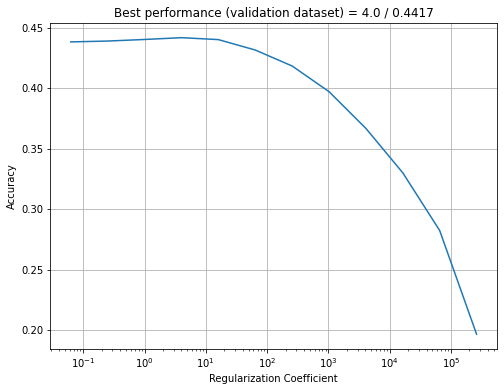

In [8]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Accuracy')
plt.title('Best performance (validation dataset) = {} / {}'.format(c_min, hit_rate_max))
plt.semilogx(v_c, v_hit_rate_v)
plt.grid(True)
plt.show()  

### Refined Search

In [9]:
v_c2 = []
v_hit_rate_tr2 = []
v_hit_rate_v2 = []
hit_rate_max2 = 0

"""
 Given the best crude value for the regularization coeffcient, the refined
 search will consider the interval between the previous and the subsequent
 crude values. 
"""

print('Refined search for the regularization coefficient:')

step = 0.1*(4*c_min-c_min/4)
for p in np.arange(c_min/4, 4*c_min, step, dtype=float):
  C = p
  v_c2.append(C) # Vector containing every value of crude search

  X = input_to_hidden(Xtr)
  Xt = np.transpose(X)

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.linalg.inv(np.dot(Xt, X) + C * np.identity(X.shape[1])), np.dot(Xt, Str))

  # Training set:
  S_est_tr = np.dot(X, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if Str[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr2.append(hit_rate_tr)


  X = input_to_hidden(Xv)
  # Validation set:
  S_est_v = np.dot(X, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v2.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max2:
    hit_rate_max2 = hit_rate_v
    c_min2 = C
    w_min2 = w

Refined search for the regularization coefficient:


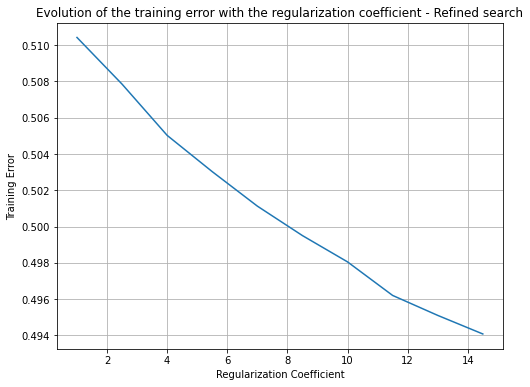

In [10]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Training Error')
plt.plot(v_c2, v_hit_rate_tr2)
plt.title('Evolution of the training error with the regularization coefficient - Refined search')
plt.grid(True)
plt.show()

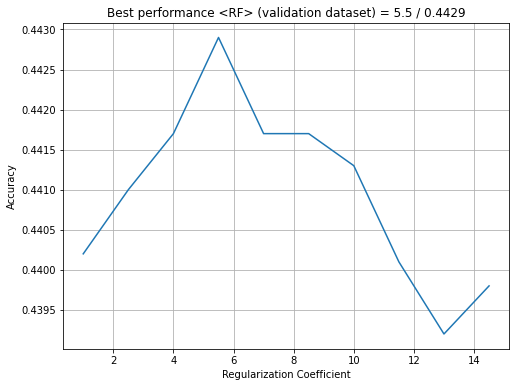

In [11]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Accuracy')
plt.title('Best performance <RF> (validation dataset) = {} / {}'.format(c_min2, hit_rate_max2))
plt.plot(v_c2, v_hit_rate_v2)
plt.grid(True)
plt.show()

### Test set Accuracy

In [12]:
Xtot = np.append(Xtr, Xv, axis=0)
Stot = np.append(Str, Sv, axis=0)

X = input_to_hidden(Xtot)
Xt = np.transpose(X)

w = np.dot(np.linalg.inv(np.dot(Xt, X) + c_min2 * np.identity(X.shape[1])), np.dot(Xt, Stot))

# Nt, mt = Xtest.shape

X = input_to_hidden(Xtest)
S_est_t = np.dot(X, w)
hit_t = 0
Nt, mt = Xtest.shape

for i in range(Nt):
  indmax = np.argmax(S_est_t[i,:], axis=0)
  if Stest[i,indmax] > .5:
    hit_t+=1
  hit_rate_t = hit_t/Nt

print('Correct classification rate for the test dataset: {}'.format(hit_rate_t))

Correct classification rate for the test dataset: 0.453


In [13]:
Xtest.shape

(10000, 3072)

In [14]:
one_hot_predictions = np.zeros((S_est_t.shape), dtype=int)
for i in range(S_est_t.shape[0]):
  max_i = np.argmax(S_est_t[i,:], axis=0)
  one_hot_predictions[i, max_i] = 1

print('Check if the first five elements converges')
print('Predictions:\n', one_hot_predictions[:5,:])
print('Labels:\n', Stest[:5,:])

Check if the first five elements converges
Predictions:
 [[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]]
Labels:
 [[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


### Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(Stest.argmax(axis=1), one_hot_predictions.argmax(axis=1), labels=[1,2,3,4,5,6,7,8,9,0])
cf_matrix

array([[572,   9,  16,  10,  32,  28,  44,  87, 163,  39],
       [ 52, 279,  63, 105,  84, 117,  97,  50,  37, 116],
       [ 72,  69, 238,  47, 194, 134,  70,  50,  70,  56],
       [ 33, 127,  38, 334,  76, 129, 113,  45,  31,  74],
       [ 45,  89, 144,  73, 350, 101,  96,  41,  33,  28],
       [ 44,  66,  56,  85,  67, 556,  41,  30,  37,  18],
       [ 44,  35,  57,  74,  67,  38, 512,  33,  88,  52],
       [ 67,  10,  20,  15,  32,  13,  24, 644,  67, 108],
       [183,   7,  19,   7,  24,  27,  56, 102, 531,  44],
       [ 51,  56,  15,  21,  15,  23,  45, 199,  61, 514]])

<Figure size 576x432 with 0 Axes>

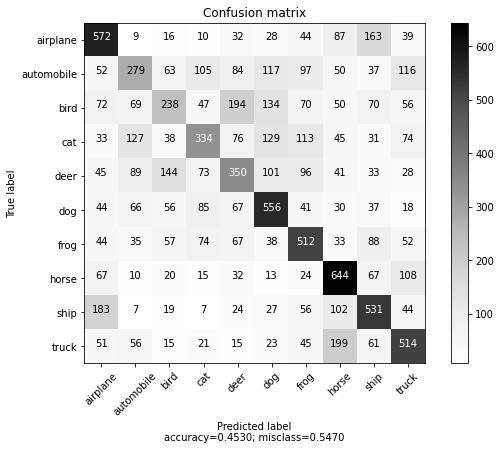

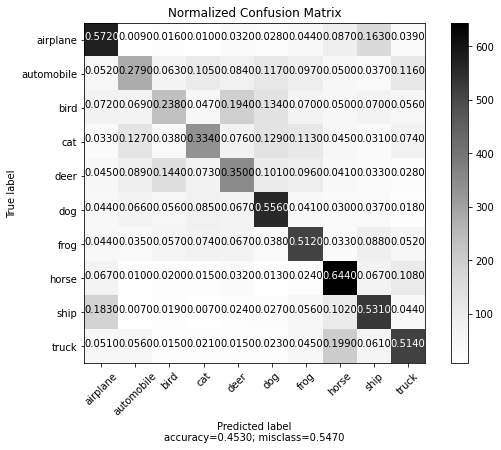

In [16]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plt.figure(figsize=(8, 6))  

plot_confusion_matrix(cf_matrix, cmap='Greys', target_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'], normalize=False)
plot_confusion_matrix(cf_matrix, title='Normalized Confusion Matrix',cmap='Greys', target_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'], normalize=True)


In [17]:
true_class = np.argmax(Stest[8,:], axis=0)
print(true_class)

pred_class = np.argmax(one_hot_predictions[8,:], axis=0)
pred_class

3


5

In [18]:
indexes = []
for i in range(Stest.shape[0]):
  true_class = np.argmax(Stest[i,:], axis=0)
  pred_class = np.argmax(one_hot_predictions[i,:], axis=0)
  if true_class != pred_class:
    indexes.append(i)

indexes[:5]

[1, 3, 4, 8, 10]

In [19]:
indexes[:10]

[1, 3, 4, 8, 10, 12, 17, 20, 21, 22]

In [20]:
predicted = np.argmax(one_hot_predictions, axis=1) +1

## Melhorias na ELM

Double neurons (3000)

In [22]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# TRAINING SET
train1 = scipy.io.loadmat('/content/train1.mat')
train2 = scipy.io.loadmat('/content/train2.mat')

Xtr1 = train1['Xtr']
Str1 = train1['Str']
Xtr2 = train2['Xtr']
Str2 = train2['Str']

Xtr = np.append(Xtr1, Xtr2, axis=0)
Str = np.append(Str1, Str2, axis=0)

# VALIDATION SET
valid = scipy.io.loadmat('/content/valid.mat')

Xv = valid['Xv']
Sv = valid['Sv']

# TEST SET
test = scipy.io.loadmat('/content/test.mat')

Xtest = test['Xt']
Stest = test['St']

print('Training Set:')
print('Xtr shape: ', Xtr.shape)
print('Str shape: ', Str.shape)

print('Validation Set:')
print('Xv shape:', Xv.shape)
print('Sv shape:', Sv.shape)

print('Test Set:')
print('Xt shape:', Xtest.shape)
print('St shape:', Stest.shape)

Training Set:
Xtr shape:  (40000, 3072)
Str shape:  (40000, 10)
Validation Set:
Xv shape: (10000, 3072)
Sv shape: (10000, 10)
Test Set:
Xt shape: (10000, 3072)
St shape: (10000, 10)


In [23]:
INPUT_LENGHT = Xtr.shape[1] # 784
HIDDEN_UNITS = 3000

Vin = np.random.normal(size=[INPUT_LENGHT, HIDDEN_UNITS],loc=0.0, scale=0.01)
print('Input Weight shape: {shape}'.format(shape=Vin.shape))


Input Weight shape: (3072, 3000)


In [24]:
ones = np.ones((INPUT_LENGHT, 1))

Vin = np.append(ones, Vin, axis = 1)

Vin.shape

(3072, 3001)

In [25]:
def input_to_hidden(x):
    a = np.matmul(x, Vin)
    a = np.maximum(a, 0, a) # ReLU
    return a

### Crude search for the regularization coefficient:

In [26]:
N, m = Xtr.shape 
Nv, mv = Xv.shape

v_c = []
v_hit_rate_tr = []
v_hit_rate_v = []
hit_rate_max = 0


print('Crude search for the regularization coefficient:')

for p in np.arange(-4, 20, 2, dtype=float):
  C = 2**(p)
  v_c.append(C) # Vector containing every value of crude search

  X = input_to_hidden(Xtr)
  Xt = np.transpose(X)

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.linalg.inv(np.dot(Xt, X) + C * np.identity(X.shape[1])), np.dot(Xt, Str))

  # Training set:
  S_est_tr = np.dot(X, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if Str[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr.append(hit_rate_tr)


  X = input_to_hidden(Xv)
  # Validation set:
  S_est_v = np.dot(X, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max:
    hit_rate_max = hit_rate_v
    c_min = C
    w_min = w


Crude search for the regularization coefficient:


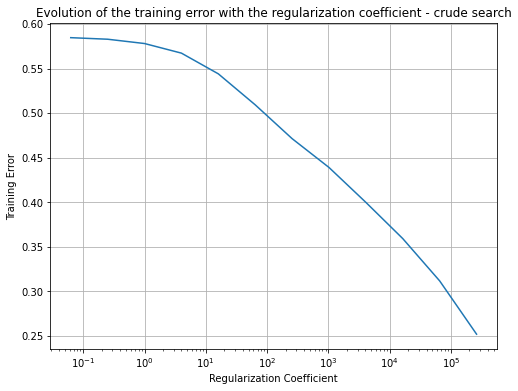

In [27]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Training Error')
plt.semilogx(v_c, v_hit_rate_tr)
plt.title('Evolution of the training error with the regularization coefficient - crude search')
plt.grid(True)
plt.show()


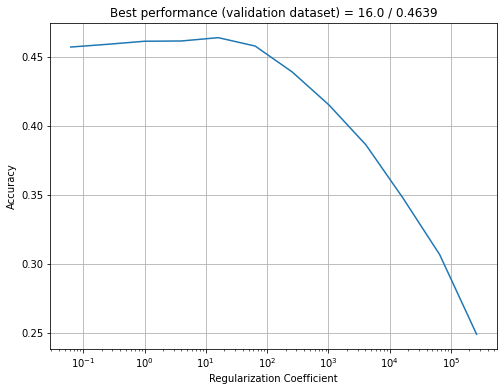

In [28]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Accuracy')
plt.title('Best performance (validation dataset) = {} / {}'.format(c_min, hit_rate_max))
plt.semilogx(v_c, v_hit_rate_v)
plt.grid(True)
plt.show()

### Refined Search

In [30]:
v_c2 = []
v_hit_rate_tr2 = []
v_hit_rate_v2 = []
hit_rate_max2 = 0

"""
 Given the best crude value for the regularization coeffcient, the refined
 search will consider the interval between the previous and the subsequent
 crude values. 
"""

print('Refined search for the regularization coefficient:')

step = 0.1*(4*c_min-c_min/4)
for p in np.arange(c_min/4, 4*c_min, step, dtype=float):
  C = p
  v_c2.append(C) # Vector containing every value of crude search

  X = input_to_hidden(Xtr)
  Xt = np.transpose(X)

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.linalg.inv(np.dot(Xt, X) + C * np.identity(X.shape[1])), np.dot(Xt, Str))

  # Training set:
  S_est_tr = np.dot(X, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if Str[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr2.append(hit_rate_tr)


  X = input_to_hidden(Xv)
  # Validation set:
  S_est_v = np.dot(X, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v2.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max2:
    hit_rate_max2 = hit_rate_v
    c_min2 = C
    w_min2 = w

Refined search for the regularization coefficient:


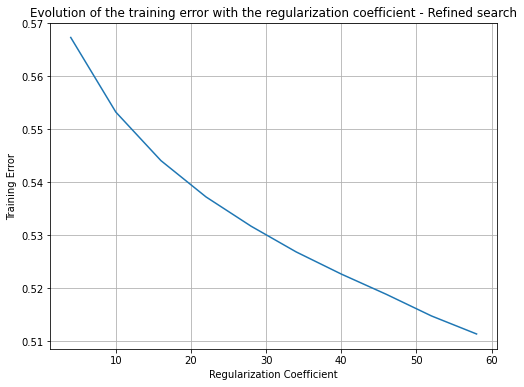

In [31]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Training Error')

plt.plot(v_c2, v_hit_rate_tr2)
plt.title('Evolution of the training error with the regularization coefficient - Refined search')
plt.grid(True)
plt.show()

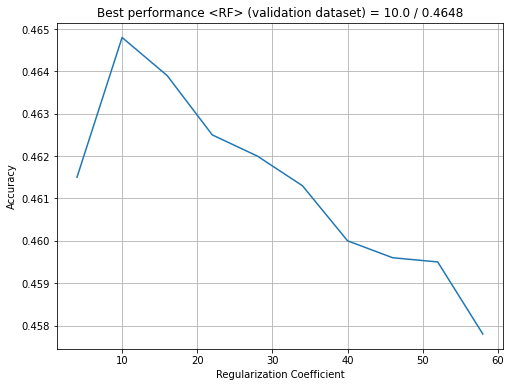

In [32]:
plt.figure(figsize=(8, 6))  
plt.xlabel('Regularization Coefficient')
plt.ylabel('Accuracy')
plt.title('Best performance <RF> (validation dataset) = {} / {}'.format(c_min2, hit_rate_max2))
plt.plot(v_c2, v_hit_rate_v2)
plt.grid(True)
plt.show()

In [34]:
Xtot = np.append(Xtr, Xv, axis=0)
Stot = np.append(Str, Sv, axis=0)

X = input_to_hidden(Xtot)
Xt = np.transpose(X)

w = np.dot(np.linalg.inv(np.dot(Xt, X) + c_min2 * np.identity(X.shape[1])), np.dot(Xt, Stot))

# Nt, mt = Xtest.shape

X = input_to_hidden(Xtest)
S_est_t = np.dot(X, w)
hit_t = 0
Nt, mt = Xtest.shape

for i in range(Nt):
  indmax = np.argmax(S_est_t[i,:], axis=0)
  if Stest[i,indmax] > .5:
    hit_t+=1
  hit_rate_t = hit_t/Nt

print('Correct classification rate for the test dataset: {}'.format(hit_rate_t))

Correct classification rate for the test dataset: 0.4785
